In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [55]:
# Load data
data = pd.read_csv('patients_data_with_RVoutcomes.csv')

# Clean data
data = data.dropna(subset=['Birthday', 'RV Dysfunction'])
data = data[data['RV Dysfunction'] != '0']

# Select features
columns_to_exclude = ['patid', 'patkey', 'rhcId','RHCDate', 'TTEDate', 'AVr_str', 'PVr_str', 'TVr_str', 'MVr_str']
data = data.drop(columns=columns_to_exclude)

In [56]:
missing_percentages = data.isnull().mean() * 100

# Identify columns with more than 20% missing data
columns_to_drop = missing_percentages[missing_percentages > 20].index

# Drop these columns from the dataset
data_cleaned = data.drop(columns=columns_to_drop)

# Display the columns dropped
print(f"Columns dropped: {columns_to_drop.tolist()}")

Columns dropped: ['CO_td', 'LVs', 'LVd', 'LVmin', 'SAs', 'SAd', 'HR_tte', 'EA', 'VLA', 'MVmg', 'TVmg', 'PVpg']


In [58]:
# Convert 'Birthday' to Age
if 'Birthday' in data.columns:
    data['Birthday'] = pd.to_datetime(data['Birthday'], format="%d-%b-%y", errors='coerce')
    data = data.dropna(subset=['Birthday'])  # Drop rows where Birthday conversion failed

    today = pd.to_datetime('today')
    data['Age'] = (today - data['Birthday']).dt.days / 365.25  

data = data.drop(columns=['Birthday'], errors='ignore')

# Select numerical features for X
X = data.select_dtypes(include=[np.number]).drop(columns=['RV Dysfunction'], errors='ignore')

# Encode target variable into binary labels
Y = data['RV Dysfunction'].replace({
    'Moderate': 'High Dysfunction',
    'Severe': 'High Dysfunction',
    'Normal': 'Low Dysfunction',
    'Mild': 'Low Dysfunction'
})

label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y_encoded, test_size=0.2, random_state=42)


In [65]:
def train_and_evaluate(model, model_name, X_train, Y_train, X_test, Y_test):
    """
    Trains and evaluates a classification model.
    Prints classification report, confusion matrix, and calculates ROC AUC.
    """
    print(f"\n--- {model_name} ---")

    # Train the model
    model.fit(X_train, Y_train)

    # Make predictions
    Y_pred = model.predict(X_test)

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(Y_test, Y_pred))

    # Print confusion matrix
    print("\nConfusion Matrix:")
    cm = confusion_matrix(Y_test, Y_pred)
    cm_df = pd.DataFrame(cm)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='YlGnBu')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # Calculate ROC AUC
    if hasattr(model, "predict_proba"):  # Ensure the model supports probability predictions
        Y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of class 1
        roc_auc = roc_auc_score(Y_test, Y_pred_proba)

        print(f"ROC AUC: {roc_auc:.4f}")

        # Plot ROC Curve
        fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_proba)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc="lower right")
        plt.show()
    
    return model

def tune_hyperparameters(X_train, y_train, n_iter=20, cv=5, random_state=42):
    """
    Tunes hyperparameters for a Random Forest classifier using RandomizedSearchCV.
    
    Parameters:
    - X_train: Training feature matrix.
    - y_train: Training labels.
    - n_iter: Number of random parameter sets to try (default: 20).
    - cv: Number of cross-validation folds (default: 5).
    - random_state: Random seed for reproducibility (default: 42).
    
    Returns:
    - best_model: The trained Random Forest model with the best hyperparameters.
    - best_params: The best hyperparameter combination found.
    """
    
    # Define the hyperparameter search space
    param_dist = {
        'n_estimators': [100, 150, 200, 250, 300, 350, 400],
        'max_depth': [None, 10, 20, 30, 40],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 3, 5],
        'max_features': [None, 'sqrt', 'log2'],
        'bootstrap': [True, False]
    }
    
    # Initialize the Random Forest classifier
    rf = RandomForestClassifier(random_state=random_state)
    
    # Perform Randomized Search with Cross-Validation
    random_search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_dist,
        n_iter=n_iter,
        cv=cv,
        scoring='accuracy',
        random_state=random_state,
        n_jobs=-1,
        error_score='raise'
    )
    
    # Fit the model
    random_search.fit(X_train, y_train)
    
    # Extract the best model and parameters
    best_model = random_search.best_estimator_
    best_params = random_search.best_params_
    
    return best_model, best_params


--- Default Random Forest ---

Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.24      0.32        33
           1       0.66      0.84      0.74        58

    accuracy                           0.63        91
   macro avg       0.57      0.54      0.53        91
weighted avg       0.59      0.63      0.59        91


Confusion Matrix:


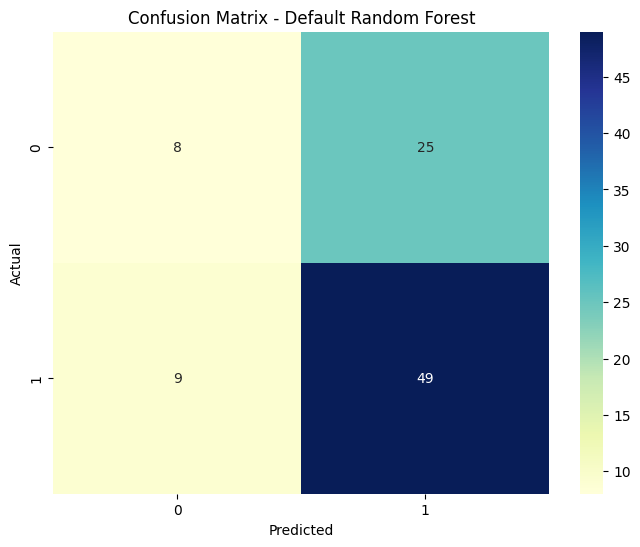

ROC AUC: 0.6021


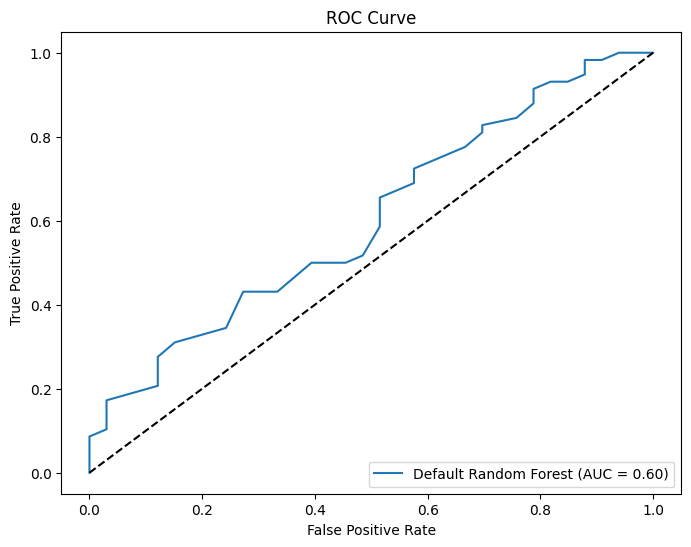

In [66]:
# Train and evaluate the default Random Forest model
default_model = RandomForestClassifier(random_state=42)
default_model = train_and_evaluate(default_model, "Default Random Forest", X_train, y_train, X_test, y_test)

In [67]:
# Tune hyperparameters for the Random Forest model
best_model, best_params = tune_hyperparameters(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")

Best Hyperparameters:
n_estimators: 200
min_samples_split: 2
min_samples_leaf: 3
max_features: None
max_depth: 10
bootstrap: True



--- Tuned Random Forest ---

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.36      0.44        33
           1       0.70      0.84      0.77        58

    accuracy                           0.67        91
   macro avg       0.64      0.60      0.61        91
weighted avg       0.65      0.67      0.65        91


Confusion Matrix:


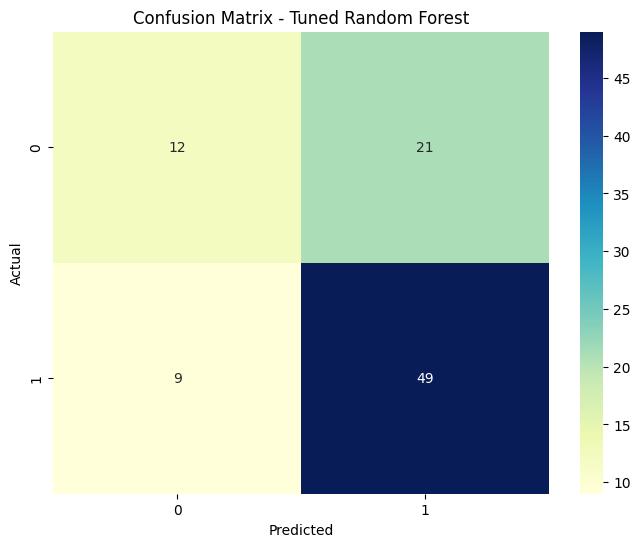

ROC AUC: 0.6301


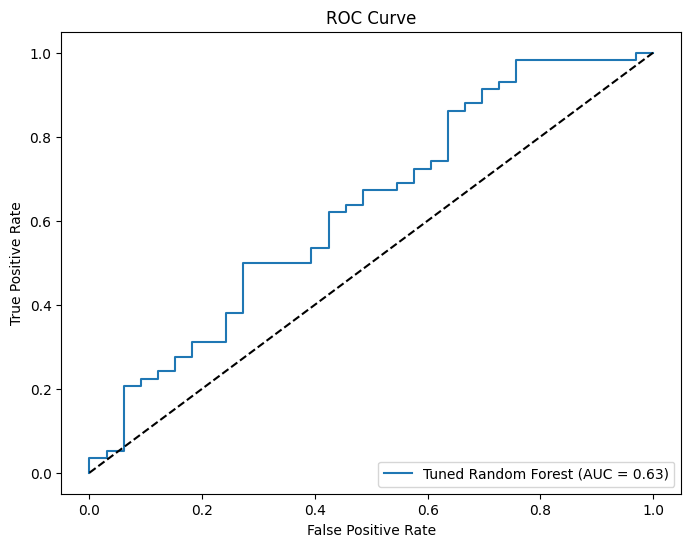

In [68]:
# Train and evaluate the Random Forest model with tuned hyperparameters
tuned_model = train_and_evaluate(best_model, "Tuned Random Forest", X_train, y_train, X_test, y_test)

In [69]:
def plot_feature_importance(model, feature_names, title="Feature Importance", top_n=20, top_n_true=False):
    """
    Plot feature importance from a Random Forest model.
    
    Parameters:
    - model: Trained Random Forest model
    - feature_names: List of feature names
    - title: Plot title
    - top_n: Number of top features to display
    """
    # Get feature importance from the model
    importances = model.feature_importances_
    print(max(importances))
    # Create a DataFrame for better visualization
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    
    plot_df = feature_importance_df
    if top_n_true:
        plot_df = feature_importance_df.head(top_n)
    
    # Create the plot
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=plot_df)
    plt.title(title)
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()
    
    return feature_importance_df


Feature Importance for Default Random Forest:
0.03644528024880477


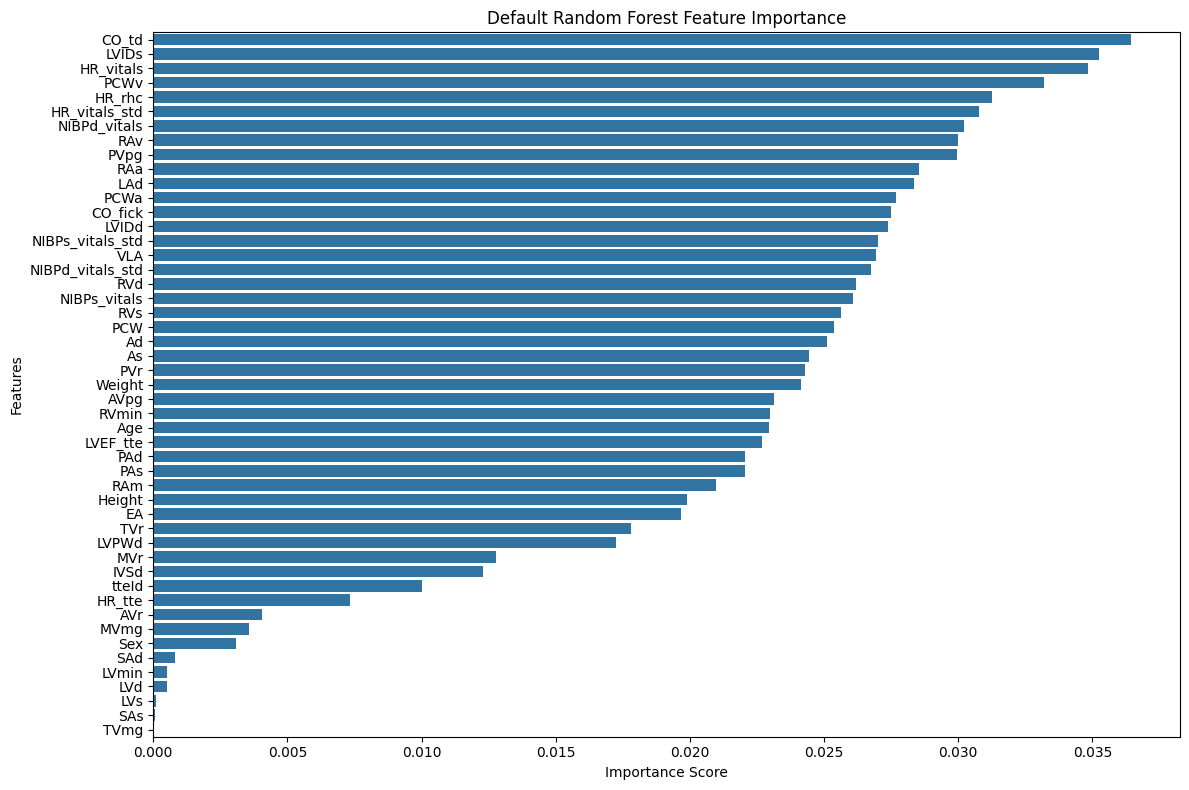


Feature Importance for Tuned Random Forest:
0.05597571255619834


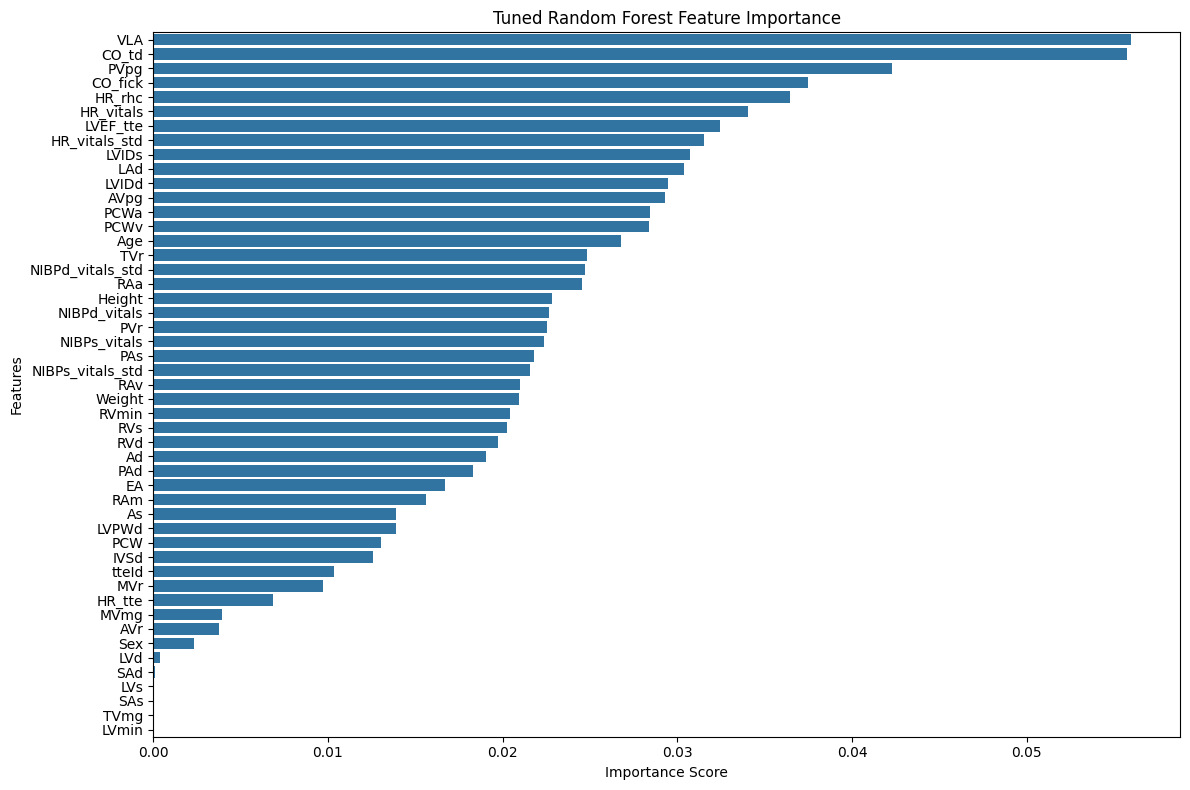

In [70]:
print("\nFeature Importance for Default Random Forest:")
importance_df_default = plot_feature_importance(default_model, X.columns, "Default Random Forest Feature Importance", False)

# After training the tuned model
print("\nFeature Importance for Tuned Random Forest:")
importance_df_tuned = plot_feature_importance(best_model, X.columns, "Tuned Random Forest Feature Importance", False) 



Feature Importance for Default Random Forest:
0.03644528024880477


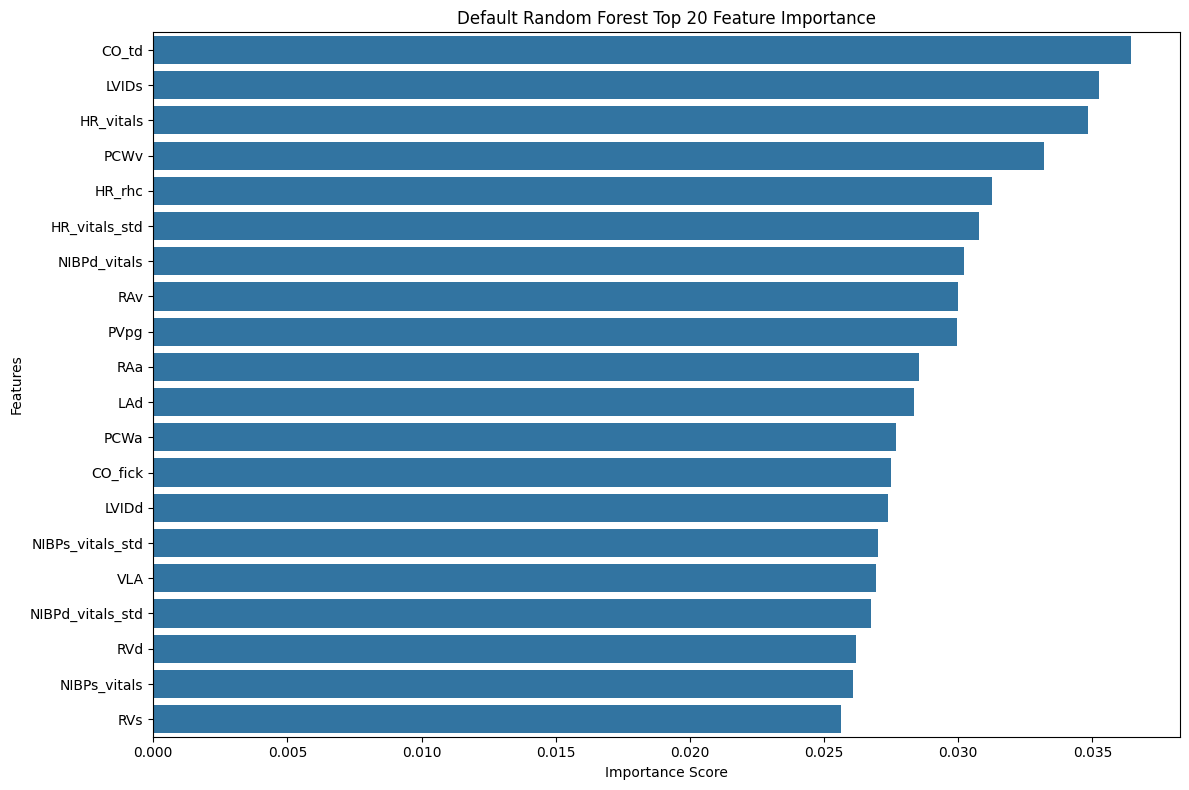


Feature Importance for Tuned Random Forest:
0.05766464460419252


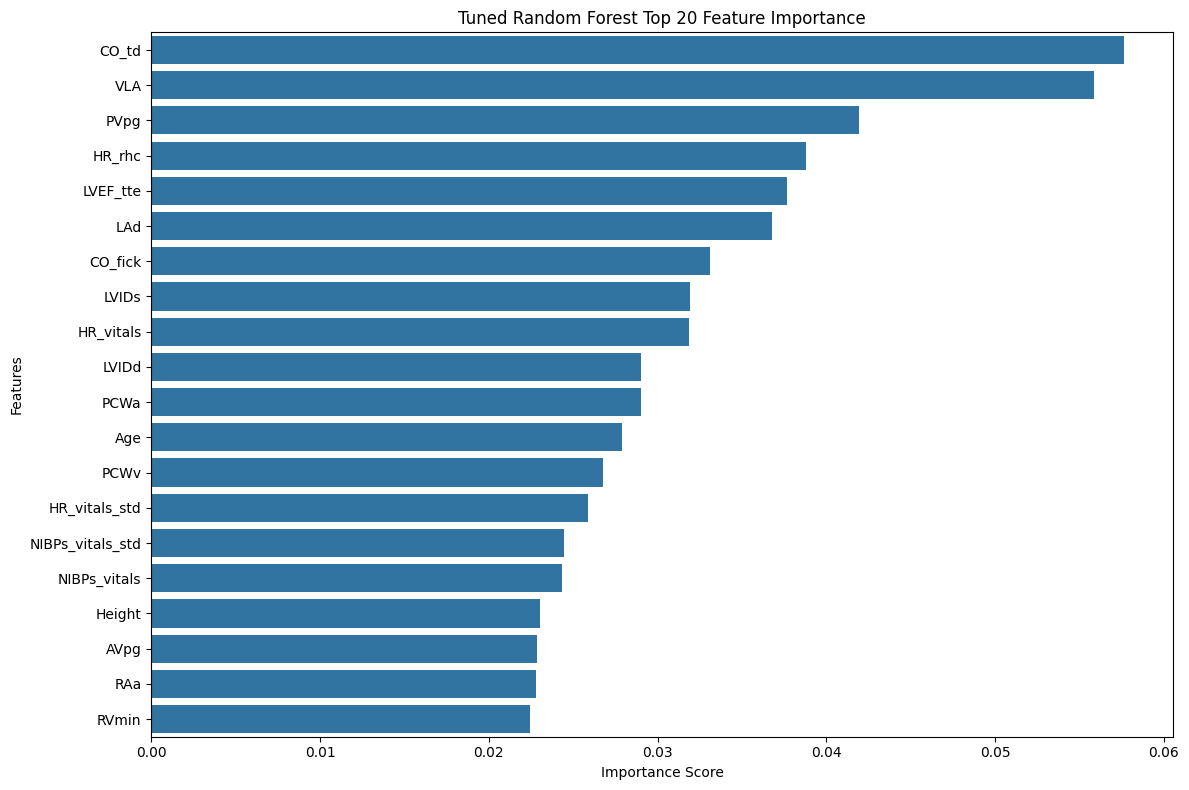

In [40]:
print("\nFeature Importance for Default Random Forest:")
importance_df_default = plot_feature_importance(default_model, X.columns, "Default Random Forest Top 20 Feature Importance", 20, True)

# After training the tuned model
print("\nFeature Importance for Tuned Random Forest:")
importance_df_tuned = plot_feature_importance(best_model, X.columns, "Tuned Random Forest Top 20 Feature Importance",20, True) 